In [1]:
import pandas as pd
from PIL import Image
import numpy as np
from matplotlib import *
from matplotlib import pyplot
from matplotlib import colors
from scipy.stats import *
from sklearn import *
import os.path

In [2]:
data=pd.read_csv('dataset.csv', delimiter=';', dtype={'id':str, 'label':str})
folder='Raw/prostata-fases-base'
data.head()


,id,label
0,ProstateX-0183-Class-3-patch.tif,cancer
1,ProstateX-0139-Class-2-patch.tif,cancer
2,ProstateX-0191-Class-1-patch.tif,cancer
3,ProstateX-0198-Class-5-patch.tif,cancer
4,ProstateX-0184-Class-3-patch.tif,cancer


In [3]:
data[['id','label']].values

array([['ProstateX-0183-Class-3-patch.tif', 'cancer'],
       ['ProstateX-0139-Class-2-patch.tif', 'cancer'],
       ['ProstateX-0191-Class-1-patch.tif', 'cancer'],
       ['ProstateX-0198-Class-5-patch.tif', 'cancer'],
       ['ProstateX-0184-Class-3-patch.tif', 'cancer'],
       ['ProstateX-0173-Class-1-patch.tif', 'cancer'],
       ['ProstateX-0026-Class-4-patch.tif', 'cancer'],
       ['ProstateX-0104-Class-2-patch.tif', 'cancer'],
       ['ProstateX-0018-Class-2-patch.tif', 'cancer'],
       ['ProstateX-0001-Class-1-patch.tif', 'cancer'],
       ['ProstateX-0014-Class-2-patch.tif', 'cancer'],
       ['ProstateX-0181-Class-5-patch.tif', 'cancer'],
       ['ProstateX-0037-Class-2-patch.tif', 'cancer'],
       ['ProstateX-0203-Class-3-patch.tif', 'cancer'],
       ['ProstateX-0095-Class-3-patch.tif', 'cancer'],
       ['ProstateX-0103-Class-5-patch.tif', 'cancer'],
       ['ProstateX-0102-Class-2-patch.tif', 'cancer'],
       ['ProstateX-0077-Class-4-patch.tif', 'cancer'],
       ['P

In [4]:
def open_image_dataset(init_folder, image_file, label):
    return np.asarray(Image.open(init_folder+'/'+label+'/'+image_file).convert('L'))
    

In [5]:
def phase_two_pi(phase_img):
    return (2*np.pi+phase_img)*(phase_img<0) + (phase_img)*(phase_img>=0)

In [6]:
def phase_to_linear(phase):
    #return (1/(2*np.pi)*(phase)) * (phase<2*np.pi)
    return 1/(2*np.pi)*phase

In [7]:
def linear_to_phase(phase):
    return 2*np.pi*phase

In [8]:
def filter_single_image(w, sigma, image):
    fourier_img=np.fft.fftshift(np.fft.fft2(image))
    [magnitude,phase]=[np.abs(fourier_img), np.angle(fourier_img)]
    
    [x,y]=np.mgrid[-np.pi:np.pi:2*np.pi/np.size(image, 0), -np.pi:np.pi:2*np.pi/np.size(image,1)]
    gaussian_multi_object=multivariate_normal(w, sigma)
    pos=np.empty(image.shape+(2, ))
    pos[:,:,0]=x
    pos[:,:,1]=y
    gaussian_f=gaussian_multi_object.pdf(pos)
    f_magnitude=magnitude*(1/(np.max(gaussian_f)))*gaussian_f
    
    return np.abs(np.fft.ifft2(np.fft.fftshift(f_magnitude*np.cos(phase) + 1j*f_magnitude*np.sin(phase))))
    

In [9]:
def filter_single_image_hp(w, sigma, image, notch_on):
    fourier_img=np.fft.fftshift(np.fft.fft2(image))
    [magnitude,phase]=[np.abs(fourier_img), np.angle(fourier_img)]
    
    [x,y]=np.mgrid[-np.pi:np.pi:2*np.pi/np.size(image, 0), -np.pi:np.pi:2*np.pi/np.size(image,1)]
    gaussian_multi_object=multivariate_normal(w, sigma)
    pos=np.empty(image.shape+(2, ))
    pos[:,:,0]=x
    pos[:,:,1]=y
    gaussian_f=gaussian_multi_object.pdf(pos)
    gaussian_f_norm = (1/(np.max(gaussian_f)))*gaussian_f
    hp_base=np.ones(np.shape(image))
    gaussian_f_hp = hp_base - gaussian_f_norm
    if notch_on:
        gaussian_f_hp = gaussian_f_hp + (gaussian_f_norm==1.).astype(float)
    
    f_magnitude=magnitude*gaussian_f_hp*(1/(np.max(gaussian_f_hp)))
    
    return np.abs(np.fft.ifft2(np.fft.fftshift(f_magnitude*np.cos(phase) + 1j*f_magnitude*np.sin(phase))))

In [10]:
def PSNR(A,B,bit):
    max_i=2**bit - 1
    MSE = np.mean((A-B)**2)
    if MSE==0:
        PSNR=float('inf')
    else:
        PSNR=10*np.log10((max_i**2)/(MSE))
    return PSNR
        

In [11]:
def get_phase_img(image, mode):
    fourier_img=np.fft.fftshift(np.fft.fft2(image))
    phase=np.angle(fourier_img)
    if mode=='linear':
        return phase_to_linear(phase_two_pi(phase))
    elif mode=='two-pi':
        return phase_two_pi(phase)
    elif mode=='normal':
        return phase
    else:
        return 0

In [12]:
def get_fourier_transform_mag_pha(image):
    fourier_img=np.fft.fftshift(np.fft.fft2(image))
    return [np.abs(fourier_img), np.angle(fourier_img)]
    

In [13]:
def fourier_inverse_from_polar(polars):
    [magnitude, phase]=[polars[0], polars[1]]
    carts = magnitude*np.cos(phase) + (1j)*magnitude*np.sin(phase)
    return np.abs(np.fft.ifft2(np.fft.fftshift(carts)))

In [14]:
images=[open_image_dataset(folder, row[0], row[1]) for row in data[['id','label']].values]

(-0.5, 29.5, 29.5, -0.5)

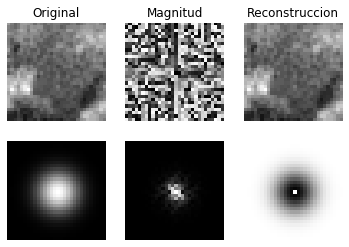

In [15]:
test_img=images[0]
img=np.asarray(test_img)
fourier_image=np.fft.fftshift(np.fft.fft2(img))
[magnitude, phase]=[np.abs(fourier_image), np.angle(fourier_image)]
fourier_image_to_rev=magnitude*np.cos(phase) + 1j*magnitude*np.sin(phase)
image_rev=np.round(np.real(np.fft.ifft2(np.fft.fftshift(fourier_image_to_rev))))

x,y=np.mgrid[-np.pi:np.pi:2*np.pi/np.size(img,0),-np.pi:np.pi:2*np.pi/np.size(img,1)]
dist=multivariate_normal([0,0], [np.pi/4, np.pi/4])
pos=np.empty(x.shape+(2,))
pos[:,:,0]=x
pos[:,:,1]=y
dist_pdf=dist.pdf(pos)
g_filter=dist_pdf/np.max(dist_pdf)
hp_filter = np.ones(np.shape(test_img)) - g_filter
hp_filter_n = hp_filter/np.max(hp_filter)
hp_filter_n = hp_filter_n + (g_filter==1.).astype(float)

filtered_magnitude=(magnitude)*(g_filter)

pyplot.subplot(2,3,1)
pyplot.imshow(img, norm=colors.Normalize(vmin=0, vmax=255, clip=False), cmap='gray')
pyplot.axis(False)
pyplot.title('Original')

pyplot.subplot(2,3,2)
pyplot.imshow(phase_two_pi(phase), norm=colors.Normalize(vmin=0, vmax=2*np.pi, clip=False), cmap='gray')
pyplot.axis(False)
pyplot.title('Magnitud')

pyplot.subplot(2,3,3)
pyplot.imshow(image_rev, norm=colors.Normalize(vmin=0, vmax=255, clip=False), cmap='gray')
pyplot.axis(False)
pyplot.title('Reconstruccion')

pyplot.subplot(2,3,4)
pyplot.imshow(dist_pdf/np.max(dist_pdf), norm=colors.Normalize(vmin=0, vmax=1), cmap='gray')
pyplot.axis(False)

pyplot.subplot(2,3,5)
pyplot.imshow(filtered_magnitude, norm=colors.Normalize(vmin=0, vmax=10000), cmap='gray')
pyplot.axis(False)


pyplot.subplot(2,3,6)
pyplot.imshow(hp_filter_n, norm=colors.Normalize(vmin=0, vmax=1), cmap='gray')
pyplot.axis(False)


In [16]:
labels=pd.unique(data['label'])
phases=[]
phases_comp=[]
count_label=0
for label in labels:
    data_q=data[data.label == label]
    images_q=[open_image_dataset(folder, row[0], row[1]) for row in data_q[['id','label']].values]
    phase_images=[phase_to_linear(get_phase_img(image, 'two-pi')) for image in images_q]
    filtered_phase_images=[linear_to_phase(filter_single_image_hp([0.,0.], [np.pi/2, np.pi/2], phase, notch_on=True)) for phase in phase_images]
    rep=np.mean(filtered_phase_images, axis=0)
    #rep=np.squeeze(stats.mode(phase_images, axis=0).mode)
    phases.append(rep)
    
    #Variables para comparar
    phase_comp=[np.degrees(get_phase_img(image,'two-pi')).astype(int) for image in images_q]
    rep_b=np.mean(phase_comp, axis=0)
    phases_comp.append(np.deg2rad(rep_b))
    #Fin variables para comparar
    
    images_all=[open_image_dataset(folder, row[0], row[1]) for row in data[['id','label']].values]
    ids=data['id'].values
    labels_i=data['label'].values
    count_img=0
    
    for im in images_all:
        [magnitude, phase]=get_fourier_transform_mag_pha(im)
        img_inverse=fourier_inverse_from_polar([magnitude, phases[count_label]])
        img_inverse_norm=255*img_inverse/np.max(img_inverse)
        img=Image.fromarray(img_inverse_norm.astype(np.uint8), mode='L')
        folder_root=folder.split('/')[0]
        if not os.path.exists(folder_root+'/'+'Prostata-fases-'+label+'/'+labels_i[count_img]):
            os.makedirs(folder_root+'/'+'Prostata-fases-'+label+'/'+labels_i[count_img])
        img.save(folder_root+'/'+'Prostata-fases-'+label+'/'+ labels_i[count_img]+'/'+ids[count_img])
        count_img=count_img+1
    
    count_label=count_label+1

In [17]:
def get_feature_matrix_patches(images, m, n):
    size=np.shape(images[0])
    count=0
    for image in images:
        tiles=image.reshape(int(size[0]/m),m,-1,n).swapaxes(2,1).reshape(-1, m*n)
        if count==0:
            features=tiles
        else:
            features=np.append(features,tiles,axis=0)
        count+=1
    return features
            

In [18]:
def get_image_patches(image, m, n):
    size=np.shape(image)
    return image.reshape(int(size[0]/m),m,-1,n).swapaxes(2,1).reshape(-1, m*n)

In [19]:
def get_image_from_patches(tiles, m, n, u, v):
    return tiles.reshape(-1,u,v).reshape(int(m/u),-1,u,v).swapaxes(1,2).reshape(m,n)

In [20]:
def compute_k_means_model(feature_matrix, k):
    return cluster.KMeans(n_clusters=k, random_state=0).fit(feature_matrix)

In [21]:
def predict_centroid(feature_row, clustering_model):
    return clustering_model.cluster_centers_[clustering_model.predict(feature_row)]

In [40]:
def set_k_clustering(feature_matrix):
    p_val=0
    k=1
    while p_val<0.97:
        clustering_model=cluster.KMeans(n_clusters=k, random_state=0).fit(preprocess_features(feature_matrix))
        labels=clustering_model.labels_
        p_values=[]
        p_p_val=[]
        N = np.shape(feature_matrix)[0]
        for i in range(k):
            features_cluster=feature_matrix[np.where(labels==i)].reshape(-1)
            try: 
                kurt,p=normaltest(features_cluster)
                p_values.append(p)
                p_p_val.append(np.shape(feature_matrix[np.where(labels==i)])[0]/N)
            except:
                continue 
        #p_val=np.sum(np.multiply(p_values, p_p_val))
        p_val=np.max(p_values)
        print('K: '+str(k)+', p-val: '+str(p_val))
        #print(p_values)
        #print(p_p_val)
        k+=1
    return k     

In [41]:
def preprocess_features(feature_matrix):
    size=np.shape(feature_matrix)
    new_feat=[]
    for i in range(size[0]):
        new_row=[np.mean(feature_matrix[i]), np.var(feature_matrix[i])]
        #new_row=[np.mean(feature_matrix[i])]
        new_feat.append(new_row)
    return np.asarray(new_feat)

In [42]:
labels=pd.unique(data['label'])
phases=[]
phases_comp=[]
count_label=0
for label in labels:
    data_q=data[data.label == label]
    images_q=[open_image_dataset(folder, row[0], row[1]) for row in data_q[['id','label']].values]
    phase_images=[get_phase_img(image, 'two-pi') for image in images_q]
    feature_matrix=get_feature_matrix_patches(phase_images,3,3)
    k = set_k_clustering(feature_matrix)
    print(k)

K: 1, p-val: 0.0
K: 2, p-val: 0.0
K: 3, p-val: 0.0
K: 4, p-val: 2.383484593083994e-151
K: 5, p-val: 4.022311718883917e-74
K: 6, p-val: 1.1888554661992787e-69
K: 7, p-val: 3.3649164972017896e-71
K: 8, p-val: 4.565361090929209e-67
K: 9, p-val: 1.9211187416467643e-62
K: 10, p-val: 7.289047652231228e-57
K: 11, p-val: 1.9932076152900328e-27
K: 12, p-val: 2.7433752912136537e-11
K: 13, p-val: 0.29122992081680826
K: 14, p-val: 0.11580962090561205
K: 15, p-val: 1.1324635471029117e-07
K: 16, p-val: 0.7963531432608303
K: 17, p-val: 0.5598612559351805
K: 18, p-val: 0.00021634585090145756
K: 19, p-val: 0.00012664717885320533
K: 20, p-val: 0.05136468182136711
K: 21, p-val: 0.0013935965114585394
K: 22, p-val: 0.893906975125889
K: 23, p-val: 0.7388254884071112
K: 24, p-val: 0.4831257648801539
K: 25, p-val: 0.00607400619086262
K: 26, p-val: 0.7793310670382344
K: 27, p-val: 0.397275943689951
K: 28, p-val: 0.23210786468737984
K: 29, p-val: 0.24753285467613292
K: 30, p-val: 0.6113268677318195
K: 31, p-val

KeyboardInterrupt: 

In [ ]:
features = get_feature_matrix_patches(phase_images, 3, 3)
print(np.shape(features))
features.reshape(-1,3,3)
preprocess_features(features)

In [ ]:
pyplot.imshow(phases[1], norm=colors.Normalize(vmin=0, vmax=2*np.pi), cmap='gray')
pyplot.axis(False)
np.mean((phases_comp[1]-phases[1])**2)
#pyplot.imshow(phase_images_f[5], norm=colors.Normalize(vmin=0, vmax=1), cmap='gray')

(array([4., 2., 4., 2., 2., 3., 4., 1., 5., 3.]),
 array([0.07278514, 0.15467696, 0.23656879, 0.31846061, 0.40035244,
        0.48224426, 0.56413609, 0.64602791, 0.72791973, 0.80981156,
        0.89170338]),
 <a list of 10 Patch objects>)

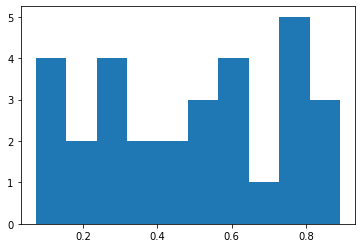

In [203]:
pyplot.hist(np.squeeze(phase_images[:][14][21]), 10)

In [14]:
print('diferencia de fase: '+str(np.max(phases[0]-phases[1])))
pyplot.imshow(phases[0]-phases[1])

NameError: name 'phases' is not defined

In [15]:
data_q[['id','label']].values
np.shape(images)

NameError: name 'data_q' is not defined

In [138]:
np.max(phases[0]-phases[1])

0.885143750476542

In [151]:
stats.mode(phase_images, axis=0).mode

array([[[180, 187, 182,  27,  14,  24, 278,  20,  29,  72, 116, 130,
         148,  88,  22, 180, 337, 178, 128, 159, 243, 287, 330,  93,
          81, 104,  81,  86,   1,   0],
        [  5, 137, 242,  42,  52,  41, 110,  12,  24, 304,  35,  19,
          21,  63,   1,  38,   1,  66,  16, 227,  70,  74, 128, 345,
           4,  18,  19,  70,  85, 117],
        [ 30,   3, 165, 101,  16,  62,   7,  76,  85,  28,   8, 318,
         164, 111,  68, 189, 341, 160, 167, 115,  86, 279,  13, 253,
         152, 151,  96,  38,   7, 198],
        [  1,   1,  44, 358,  54,  59,  49, 303, 174,  48,  59,  16,
         249, 100,   0, 220,  31,  32,  13,  21,  55, 337,  16,  44,
          51, 101,  11, 318,  21,   8],
        [162,  88,  15, 278, 197,   0,  34,  10,   6,  15, 206,  11,
          37,  11,  21, 201,  31, 102,  27,  88, 303, 165, 268,  18,
           1,   8,   2,   7, 210, 324],
        [ 76,  32,   1,  15, 116,   6,   1, 177,  60, 135, 331,  16,
         106,  45, 247,  43, 243, 227, 15